# Comprehensive Experiment: 8 Configurations

This experiment tests all combinations of:
- **Agents**: Greedy vs UCB
- **Roles**: Price-Quantity assignment
- **Partner Prediction**: With vs Without

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initial imports
import importlib
import params
import agents
import model

from model import NewsVendorModel

# ============================================================================
# EXPERIMENT GROUP 1: TEAM PLAYER SUPPLIER (Integrated Supply Chain)
# ============================================================================
print("=" * 80)
print("GROUP 1: TEAM PLAYER SUPPLIER MODE (Retailer-Only Metrics)")
print("=" * 80)

# Set to team player mode and recompute benchmarks
params.SUPPLIER_TEAM_PLAYER = True
params._compute_benchmarks()

print(f"\n🔍 Configuration:")
print(f"   SUPPLIER_TEAM_PLAYER: {params.SUPPLIER_TEAM_PLAYER}")
print(f"   Supplier action space: {params.action_space_c()}")
print(f"   Number of benchmarks: {len(params.PROFIT_OPTIMA_MAP)}\n")

experiments_team_player = [
    # (agent_types, use_partner_prediction, description)
    (['greedy', 'greedy', 'greedy'], False, 'Greedy-Greedy, No Prediction'),
    (['greedy', 'greedy', 'greedy'], True, 'Greedy-Greedy, With Prediction'),
    (['ucb', 'ucb', 'ucb'], False, 'UCB-UCB, No Prediction'),
    (['ucb', 'ucb', 'ucb'], True, 'UCB-UCB, With Prediction'),
    (['greedy', 'ucb', 'greedy'], False, 'Greedy(P)-UCB(Q), No Prediction'),
    (['greedy', 'ucb', 'greedy'], True, 'Greedy(P)-UCB(Q), With Prediction'),
    (['ucb', 'greedy', 'ucb'], False, 'UCB(P)-Greedy(Q), No Prediction'),
    (['ucb', 'greedy', 'ucb'], True, 'UCB(P)-Greedy(Q), With Prediction'),
]

team_player_results = []

for idx, (agent_types, use_prediction, description) in enumerate(experiments_team_player, 1):
    print(f"\n[{idx}/{len(experiments_team_player)}] {description}")
    print(f"  Price: {agent_types[0]}, Quantity: {agent_types[1]}, Prediction: {use_prediction}")
    
    params.USE_PARTNER_PREDICTION = use_prediction
    
    sim_model = NewsVendorModel(agent_type=agent_types)
    
    for i in range(params.ROUNDS):
        sim_model.step()
    
    model_df = sim_model.datacollector.get_model_vars_dataframe()
    agent_df = sim_model.datacollector.get_agent_vars_dataframe()
    
    df = agent_df.reset_index()
    price_data = df[df["AgentID"] == 1][["Step", "Action", "Reward"]].rename(columns={"Action": "Price"})
    qty_data = df[df["AgentID"] == 2][["Step", "Action"]].rename(columns={"Action": "Quantity"})
    supplier_data = df[df["AgentID"] == 3][["Step", "Action"]].rename(columns={"Action": "Cost"})
    
    combined_df = pd.merge(price_data, qty_data, on="Step")
    combined_df = pd.merge(combined_df, supplier_data, on="Step")
    combined_df = pd.merge(combined_df, model_df, left_on="Step", right_index=True)
    
    # Retailer metrics only
    final_regret = combined_df['Regret'].cumsum().iloc[-1]
    avg_profit = combined_df['Reward'].mean()
    final_price = combined_df['Price'].iloc[-100:].mean()
    final_quantity = combined_df['Quantity'].iloc[-100:].mean()
    price_std = combined_df['Price'].iloc[-100:].std()
    qty_std = combined_df['Quantity'].iloc[-100:].std()
    
    optimal_profit = params.PROFIT_OPTIMA_MAP.get(params.MANUFACTURING_COST, 0)
    
    team_player_results.append({
        'Config': description,
        'Price_Agent': agent_types[0],
        'Quantity_Agent': agent_types[1],
        'Prediction': use_prediction,
        'Cumulative_Regret': final_regret,
        'Avg_Profit': avg_profit,
        'Final_Price': final_price,
        'Final_Quantity': final_quantity,
        'Price_Std': price_std,
        'Qty_Std': qty_std,
        'Optimal_Profit': optimal_profit,
        'Combined_DF': combined_df.copy()
    })
    
    print(f"  ✓ Cumulative Regret: {final_regret:.2f}")
    print(f"  ✓ Average Profit: {avg_profit:.2f} (Optimal: {optimal_profit:.2f})")
    print(f"  ✓ Final Price: {final_price:.2f}, Quantity: {final_quantity:.1f}")

# ============================================================================
# EXPERIMENT GROUP 2: COMPETITIVE SUPPLIER (3-Agent Game)
# ============================================================================
print("\n" + "=" * 80)
print("GROUP 2: COMPETITIVE SUPPLIER MODE (Retailer & Supplier Profit)")
print("=" * 80)

# Switch to competitive mode and recompute benchmarks
params.SUPPLIER_TEAM_PLAYER = False
params._compute_benchmarks()

print(f"\n🔍 Supplier Configuration:")
print(f"   SUPPLIER_TEAM_PLAYER: {params.SUPPLIER_TEAM_PLAYER}")
print(f"   SUPPLIER_MAX_COST (ceiling): {params.SUPPLIER_MAX_COST:.2f}")
print(f"   Supplier step size: {params.C_STEP_SIZE:.2f}")
print(f"   SUPPLIER_OPTIMAL_COST: {params.SUPPLIER_OPTIMAL_COST:.2f}")
print(f"   Supplier action space size: {len(params.action_space_c())} actions")
print(f"   Number of benchmarks: {len(params.PROFIT_OPTIMA_MAP)}\n")

experiments_competitive = [
    # (agent_types, use_partner_prediction, description)
    (['greedy', 'greedy', 'greedy'], False, 'All-Greedy, No Prediction'),
    (['greedy', 'greedy', 'greedy'], True, 'All-Greedy, With Prediction'),
    (['ucb', 'ucb', 'ucb'], False, 'All-UCB, No Prediction'),
    (['ucb', 'ucb', 'ucb'], True, 'All-UCB, With Prediction'),
    (['greedy', 'greedy', 'ucb'], False, 'Greedy Retailers, UCB Supplier'),
    (['ucb', 'ucb', 'greedy'], False, 'UCB Retailers, Greedy Supplier'),
    (['greedy', 'ucb', 'greedy'], False, 'Greedy(P)-UCB(Q), Greedy(S)'),
    (['ucb', 'greedy', 'ucb'], False, 'UCB(P)-Greedy(Q), UCB(S)'),
]

competitive_results = []

for idx, (agent_types, use_prediction, description) in enumerate(experiments_competitive, 1):
    print(f"\n[{idx}/{len(experiments_competitive)}] {description}")
    print(f"  Price: {agent_types[0]}, Quantity: {agent_types[1]}, Supplier: {agent_types[2]}, Prediction: {use_prediction}")
    
    params.USE_PARTNER_PREDICTION = use_prediction
    
    sim_model = NewsVendorModel(agent_type=agent_types)
    
    for i in range(params.ROUNDS):
        sim_model.step()
    
    model_df = sim_model.datacollector.get_model_vars_dataframe()
    agent_df = sim_model.datacollector.get_agent_vars_dataframe()
    
    df = agent_df.reset_index()
    price_data = df[df["AgentID"] == 1][["Step", "Action", "Reward", "Cummulative Regret"]].rename(
        columns={"Action": "Price", "Reward": "Retailer_Profit", "Cummulative Regret": "Retailer_Cumulative_Regret"})
    qty_data = df[df["AgentID"] == 2][["Step", "Action"]].rename(columns={"Action": "Quantity"})
    supplier_data = df[df["AgentID"] == 3][["Step", "Action", "Reward"]].rename(
        columns={"Action": "Cost", "Reward": "Supplier_Profit"})
    
    combined_df = pd.merge(price_data, qty_data, on="Step")
    combined_df = pd.merge(combined_df, supplier_data, on="Step")
    combined_df = pd.merge(combined_df, model_df, left_on="Step", right_index=True)
    
    # Calculate metrics for both retailer and supplier
    retailer_cumulative_regret = combined_df['Retailer_Cumulative_Regret'].iloc[-1]
    avg_retailer_profit = combined_df['Retailer_Profit'].mean()
    avg_supplier_profit = combined_df['Supplier_Profit'].mean()
    final_price = combined_df['Price'].iloc[-100:].mean()
    final_quantity = combined_df['Quantity'].iloc[-100:].mean()
    final_cost = combined_df['Cost'].iloc[-100:].mean()
    price_std = combined_df['Price'].iloc[-100:].std()
    qty_std = combined_df['Quantity'].iloc[-100:].std()
    cost_std = combined_df['Cost'].iloc[-100:].std()
    
    optimal_retailer_profit = params.PROFIT_OPTIMA_MAP.get(final_cost, 0)
    
    competitive_results.append({
        'Config': description,
        'Price_Agent': agent_types[0],
        'Quantity_Agent': agent_types[1],
        'Supplier_Agent': agent_types[2],
        'Prediction': use_prediction,
        'Retailer_Cumulative_Regret': retailer_cumulative_regret,
        'Avg_Retailer_Profit': avg_retailer_profit,
        'Avg_Supplier_Profit': avg_supplier_profit,
        'Total_Supply_Chain_Profit': avg_retailer_profit + avg_supplier_profit,
        'Final_Price': final_price,
        'Final_Quantity': final_quantity,
        'Final_Cost': final_cost,
        'Price_Std': price_std,
        'Qty_Std': qty_std,
        'Cost_Std': cost_std,
        'Optimal_Retailer_Profit': optimal_retailer_profit,
        'Combined_DF': combined_df.copy()
    })
    
    print(f"  ✓ Retailer - Regret: {retailer_cumulative_regret:.2f}, Avg Profit: {avg_retailer_profit:.2f}")
    print(f"  ✓ Supplier - Avg Profit: {avg_supplier_profit:.2f}")
    print(f"  ✓ Total Supply Chain Profit: {(avg_retailer_profit + avg_supplier_profit):.2f}")
    print(f"  ✓ Final - Price: {final_price:.2f}, Quantity: {final_quantity:.1f}, Cost: {final_cost:.2f}")

print("\n" + "=" * 80)
print("ALL EXPERIMENTS COMPLETED!")
print("=" * 80)

Computing optimal benchmarks (this may take a moment)...
Supplier global optimum: cost=15.00, quantity=24, profit=312.00
Retailer optimal at manufacturing cost (c=2.00): price=17.50, quantity=40
GROUP 1: TEAM PLAYER SUPPLIER MODE (Retailer-Only Metrics)

[1/8] Greedy-Greedy, No Prediction
  Price: greedy, Quantity: greedy, Prediction: False
  ✓ Cumulative Regret: 80917.84
  ✓ Average Profit: 314.69 (Optimal: 537.82)
  ✓ Final Price: 18.07, Quantity: 28.6

[2/8] Greedy-Greedy, With Prediction
  Price: greedy, Quantity: greedy, Prediction: True
  ✓ Cumulative Regret: 65204.13
  ✓ Average Profit: 357.10 (Optimal: 537.82)
  ✓ Final Price: 16.70, Quantity: 36.0

[3/8] UCB-UCB, No Prediction
  Price: ucb, Quantity: ucb, Prediction: False
  ✓ Cumulative Regret: 23303.29
  ✓ Average Profit: 472.51 (Optimal: 537.82)
  ✓ Final Price: 18.00, Quantity: 39.0

[4/8] UCB-UCB, With Prediction
  Price: ucb, Quantity: ucb, Prediction: True
  ✓ Cumulative Regret: 28017.59
  ✓ Average Profit: 459.83 (Opti


📊 VISUALIZING GROUP 1: TEAM PLAYER SUPPLIER


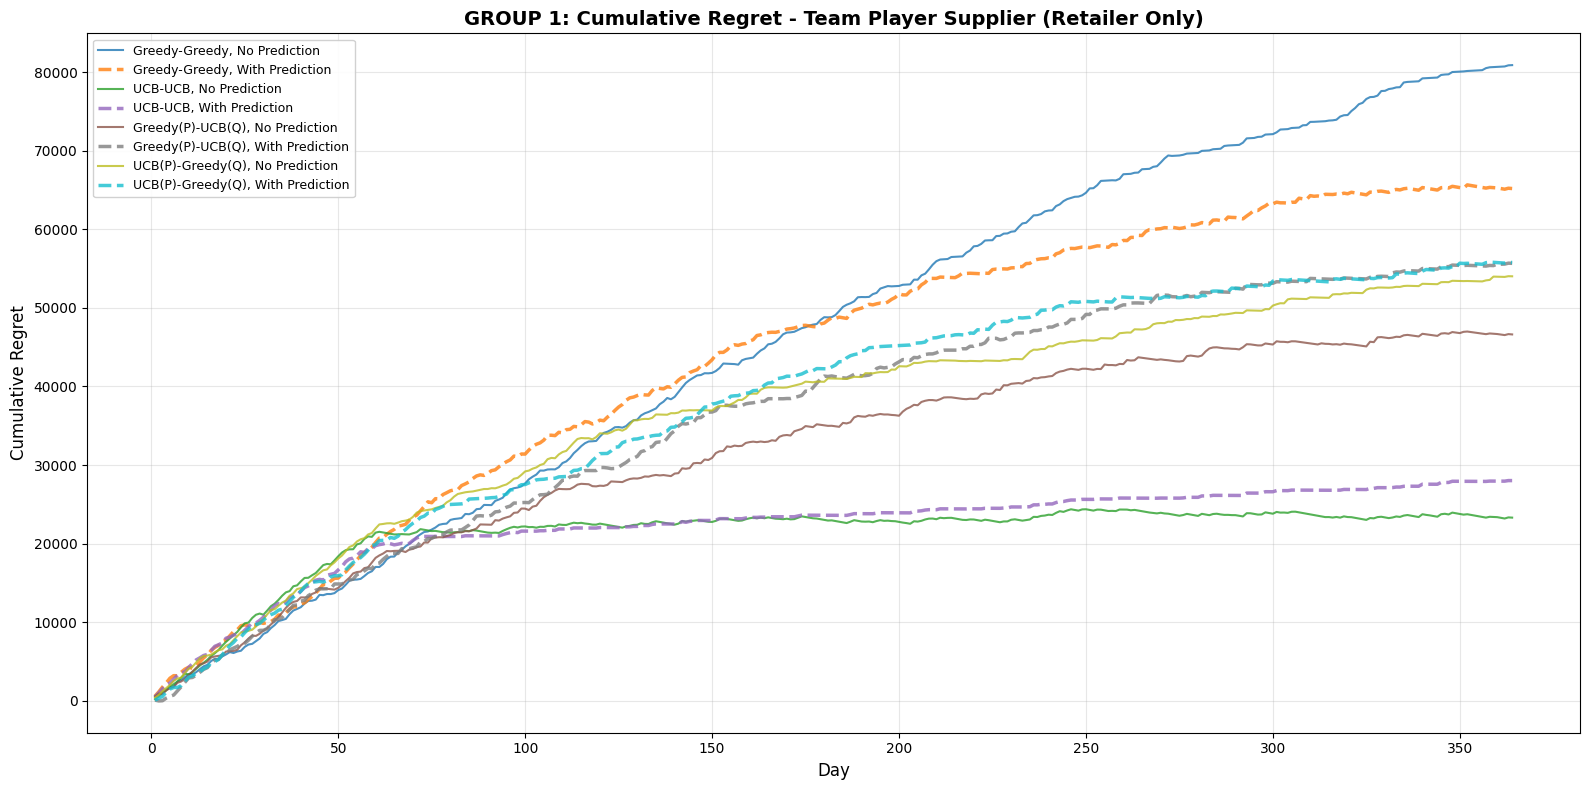

In [2]:
# ============================================================================
# VISUALIZATION: GROUP 1 - TEAM PLAYER SUPPLIER
# ============================================================================

print("\n📊 VISUALIZING GROUP 1: TEAM PLAYER SUPPLIER")

# Cumulative Regret Comparison
fig, ax = plt.subplots(figsize=(16, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(team_player_results)))

for idx, result in enumerate(team_player_results):
    df = result['Combined_DF']
    cumulative_regret = df['Regret'].cumsum()
    
    linestyle = '--' if result['Prediction'] else '-'
    linewidth = 2.5 if result['Prediction'] else 1.5
    
    ax.plot(df['Step'], cumulative_regret, 
            label=result['Config'], 
            color=colors[idx],
            linestyle=linestyle,
            linewidth=linewidth,
            alpha=0.8)

ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Cumulative Regret', fontsize=12)
ax.set_title('GROUP 1: Cumulative Regret - Team Player Supplier (Retailer Only)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


📊 VISUALIZING GROUP 2: COMPETITIVE SUPPLIER


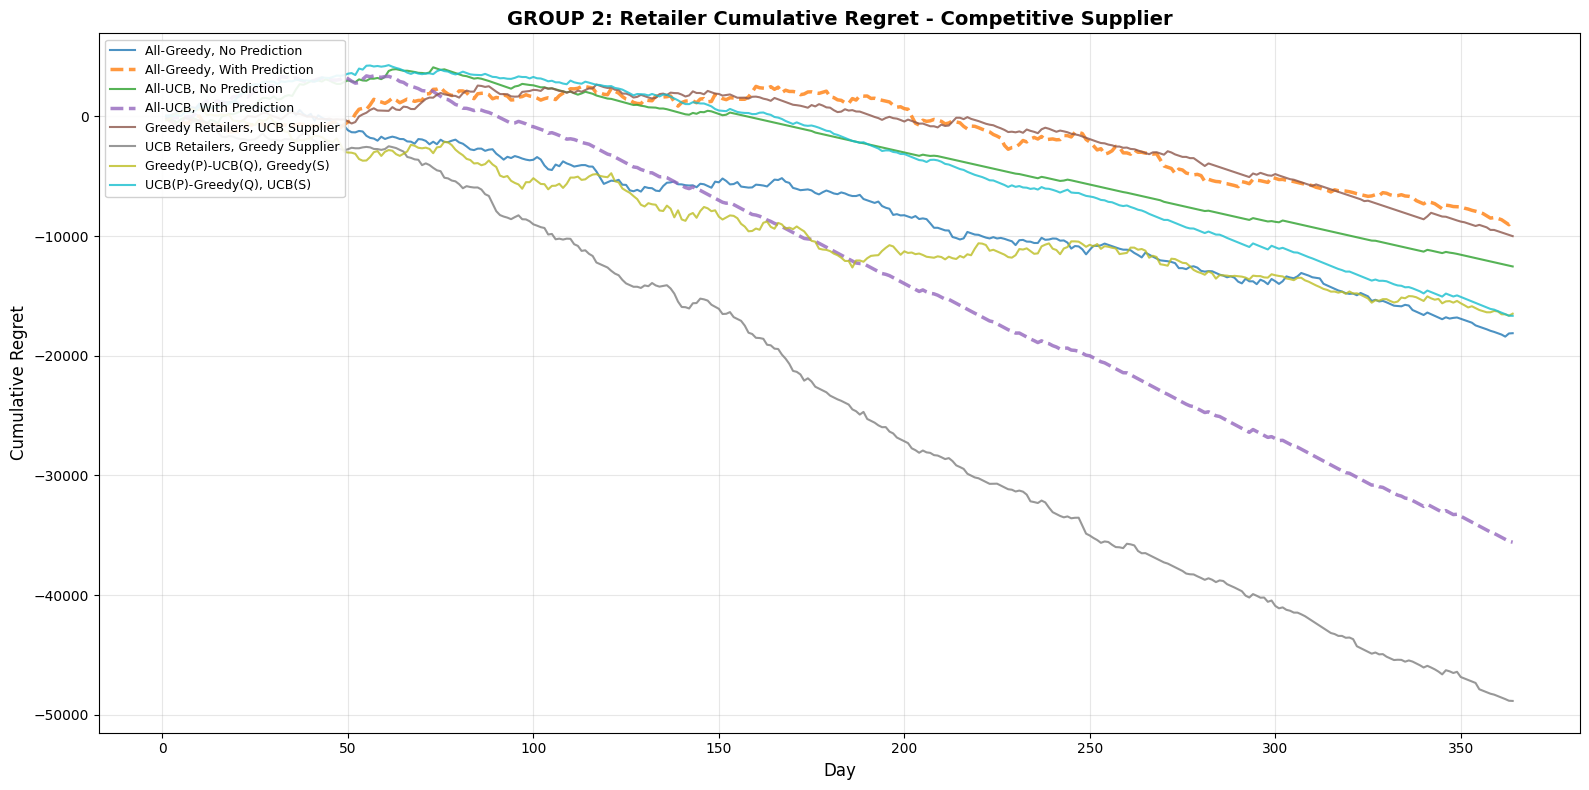

In [3]:
# ============================================================================
# VISUALIZATION: GROUP 2 - COMPETITIVE SUPPLIER
# ============================================================================

print("\n📊 VISUALIZING GROUP 2: COMPETITIVE SUPPLIER")

# Only Retailer Regret (Supplier regret not tracked)
fig, ax = plt.subplots(figsize=(16, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(competitive_results)))

for idx, result in enumerate(competitive_results):
    df = result['Combined_DF']
    
    linestyle = '--' if result['Prediction'] else '-'
    linewidth = 2.5 if result['Prediction'] else 1.5
    
    ax.plot(df['Step'], df['Retailer_Cumulative_Regret'], 
            label=result['Config'], 
            color=colors[idx],
            linestyle=linestyle,
            linewidth=linewidth,
            alpha=0.8)

ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Cumulative Regret', fontsize=12)
ax.set_title('GROUP 2: Retailer Cumulative Regret - Competitive Supplier', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
# ============================================================================
# SUMMARY ANALYSIS
# ============================================================================

print("=" * 80)
print("🔍 EXPERIMENT SUMMARY & KEY FINDINGS")
print("=" * 80)

# GROUP 1: Team Player Analysis
print("\n" + "=" * 80)
print("GROUP 1: TEAM PLAYER SUPPLIER (Integrated Supply Chain)")
print("=" * 80)

best_team = min(team_player_results, key=lambda x: x['Cumulative_Regret'])
print(f"\n✅ BEST CONFIGURATION (Lowest Regret):")
print(f"   {best_team['Config']}")
print(f"   Cumulative Regret: {best_team['Cumulative_Regret']:.2f}")
print(f"   Average Profit: {best_team['Avg_Profit']:.2f}")
print(f"   Final Price: {best_team['Final_Price']:.2f}, Quantity: {best_team['Final_Quantity']:.1f}")

# Effect of partner prediction in team player mode
no_pred_team = [r for r in team_player_results if not r['Prediction']]
with_pred_team = [r for r in team_player_results if r['Prediction']]

if with_pred_team and no_pred_team:
    avg_regret_no = np.mean([r['Cumulative_Regret'] for r in no_pred_team])
    avg_regret_with = np.mean([r['Cumulative_Regret'] for r in with_pred_team])
    print(f"\n📊 EFFECT OF PARTNER PREDICTION:")
    print(f"   Without: Avg Regret = {avg_regret_no:.2f}")
    print(f"   With:    Avg Regret = {avg_regret_with:.2f}")
    if avg_regret_no > 0:
        improvement = ((avg_regret_no - avg_regret_with) / avg_regret_no * 100)
        print(f"   Improvement: {improvement:.1f}% reduction in regret")

# GROUP 2: Competitive Analysis
print("\n" + "=" * 80)
print("GROUP 2: COMPETITIVE SUPPLIER (Three-Agent Game)")
print("=" * 80)

best_comp = min(competitive_results, key=lambda x: x['Retailer_Cumulative_Regret'])
print(f"\n✅ BEST FOR RETAILER (Lowest Retailer Regret):")
print(f"   {best_comp['Config']}")
print(f"   Retailer Regret: {best_comp['Retailer_Cumulative_Regret']:.2f}, Profit: {best_comp['Avg_Retailer_Profit']:.2f}")
print(f"   Supplier Profit: {best_comp['Avg_Supplier_Profit']:.2f}")

best_supplier_profit = max(competitive_results, key=lambda x: x['Avg_Supplier_Profit'])
print(f"\n✅ BEST FOR SUPPLIER (Highest Supplier Profit):")
print(f"   {best_supplier_profit['Config']}")
print(f"   Supplier Profit: {best_supplier_profit['Avg_Supplier_Profit']:.2f}")
print(f"   Retailer Regret: {best_supplier_profit['Retailer_Cumulative_Regret']:.2f}, Profit: {best_supplier_profit['Avg_Retailer_Profit']:.2f}")

best_total = max(competitive_results, key=lambda x: x['Total_Supply_Chain_Profit'])
print(f"\n✅ BEST SUPPLY CHAIN EFFICIENCY (Highest Total Profit):")
print(f"   {best_total['Config']}")
print(f"   Total Profit: {best_total['Total_Supply_Chain_Profit']:.2f}")
print(f"   Retailer: {best_total['Avg_Retailer_Profit']:.2f} ({best_total['Avg_Retailer_Profit']/best_total['Total_Supply_Chain_Profit']*100:.1f}%)")
print(f"   Supplier: {best_total['Avg_Supplier_Profit']:.2f} ({best_total['Avg_Supplier_Profit']/best_total['Total_Supply_Chain_Profit']*100:.1f}%)")

# COMPARISON: Team Player vs Competitive
print("\n" + "=" * 80)
print("COMPARISON: TEAM PLAYER vs COMPETITIVE SUPPLIER")
print("=" * 80)

avg_team_profit = np.mean([r['Avg_Profit'] for r in team_player_results])
avg_comp_total_profit = np.mean([r['Total_Supply_Chain_Profit'] for r in competitive_results])
avg_comp_retailer_profit = np.mean([r['Avg_Retailer_Profit'] for r in competitive_results])

print(f"\nTeam Player Mode:")
print(f"  Average Retailer Profit: {avg_team_profit:.2f}")
print(f"\nCompetitive Mode:")
print(f"  Average Total Supply Chain Profit: {avg_comp_total_profit:.2f}")
print(f"  Average Retailer Profit: {avg_comp_retailer_profit:.2f}")
print(f"  Average Supplier Profit: {np.mean([r['Avg_Supplier_Profit'] for r in competitive_results]):.2f}")

if avg_team_profit > 0:
    efficiency_loss = ((avg_team_profit - avg_comp_total_profit) / avg_team_profit * 100)
    print(f"\n💡 Double Marginalization Effect:")
    print(f"  Supply chain loses {efficiency_loss:.1f}% efficiency due to supplier markup")
    print(f"  Retailer profit decreases by {((avg_team_profit - avg_comp_retailer_profit) / avg_team_profit * 100):.1f}%")

print("\n" + "=" * 80)

🔍 EXPERIMENT SUMMARY & KEY FINDINGS

GROUP 1: TEAM PLAYER SUPPLIER (Integrated Supply Chain)

✅ BEST CONFIGURATION (Lowest Regret):
   UCB-UCB, No Prediction
   Cumulative Regret: 23303.29
   Average Profit: 472.51
   Final Price: 18.00, Quantity: 39.0

📊 EFFECT OF PARTNER PREDICTION:
   Without: Avg Regret = 51219.89
   With:    Avg Regret = 51171.30
   Improvement: 0.1% reduction in regret

GROUP 2: COMPETITIVE SUPPLIER (Three-Agent Game)

✅ BEST FOR RETAILER (Lowest Retailer Regret):
   UCB Retailers, Greedy Supplier
   Retailer Regret: -48839.54, Profit: 145.99
   Supplier Profit: 267.07

✅ BEST FOR SUPPLIER (Highest Supplier Profit):
   Greedy(P)-UCB(Q), Greedy(S)
   Supplier Profit: 312.39
   Retailer Regret: -16487.01, Profit: 54.16

✅ BEST SUPPLY CHAIN EFFICIENCY (Highest Total Profit):
   UCB Retailers, Greedy Supplier
   Total Profit: 413.07
   Retailer: 145.99 (35.3%)
   Supplier: 267.07 (64.7%)

COMPARISON: TEAM PLAYER vs COMPETITIVE SUPPLIER

Team Player Mode:
  Average Re

In [5]:
# Create Summary Tables

print("\n📋 GROUP 1: TEAM PLAYER SUPPLIER - Summary Table")
team_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'Combined_DF'} for r in team_player_results])
display(team_df[['Config', 'Cumulative_Regret', 'Avg_Profit', 'Final_Price', 'Final_Quantity', 'Prediction']])

print("\n📋 GROUP 2: COMPETITIVE SUPPLIER - Summary Table")
comp_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'Combined_DF'} for r in competitive_results])
display(comp_df[['Config', 'Retailer_Cumulative_Regret', 'Avg_Retailer_Profit', 'Avg_Supplier_Profit', 
                  'Total_Supply_Chain_Profit', 'Final_Cost', 'Prediction']])


📋 GROUP 1: TEAM PLAYER SUPPLIER - Summary Table


,Config,Cumulative_Regret,Avg_Profit,Final_Price,Final_Quantity,Prediction
0,"Greedy-Greedy, No Prediction",80917.837917,314.686571,18.065,28.59,False
1,"Greedy-Greedy, With Prediction",65204.130228,357.104041,16.705,35.98,True
2,"UCB-UCB, No Prediction",23303.288476,472.509513,18.000,39.00,False
3,"UCB-UCB, With Prediction",28017.587265,459.834237,15.500,40.00,True
4,"Greedy(P)-UCB(Q), No Prediction",46628.738032,409.393580,17.260,39.00,False
5,"Greedy(P)-UCB(Q), With Prediction",55680.874641,383.465316,17.405,36.00,True
6,"UCB(P)-Greedy(Q), No Prediction",54029.689240,388.112803,16.500,34.64,False
7,"UCB(P)-Greedy(Q), With Prediction",55782.624105,383.004466,17.000,35.54,True



📋 GROUP 2: COMPETITIVE SUPPLIER - Summary Table


,Config,Retailer_Cumulative_Regret,Avg_Retailer_Profit,Avg_Supplier_Profit,Total_Supply_Chain_Profit,Final_Cost,Prediction
0,"All-Greedy, No Prediction",-18118.358382,71.938596,235.464286,307.402882,12.84,False
1,"All-Greedy, With Prediction",-8667.211577,43.018855,238.252747,281.271603,13.22,True
2,"All-UCB, No Prediction",-12542.569407,35.935134,146.373626,182.308760,14.94,False
3,"All-UCB, With Prediction",-35578.447616,99.220514,234.711538,333.932052,13.00,True
4,"Greedy Retailers, UCB Supplier",-10009.641288,28.976540,242.618132,271.594672,13.00,False
5,"UCB Retailers, Greedy Supplier",-48839.535945,145.994755,267.071429,413.066184,13.12,False
6,"Greedy(P)-UCB(Q), Greedy(S)",-16487.014992,54.159152,312.392857,366.552009,13.82,False
7,"UCB(P)-Greedy(Q), UCB(S)",-16665.936801,47.263066,273.195055,320.458121,15.00,False


🔍 DIAGNOSTIC: SUPPLIER COST ANALYSIS

Analyzing: All-Greedy, No Prediction

1. SUPPLIER COST STATISTICS:
   Mean Cost: 10.94
   Median Cost: 14.00
   Min Cost: 0.00
   Max Cost: 15.00
   Std Dev: 4.52
   Max Ceiling: 15.00

2. RETAILER PROFIT STATISTICS:
   Mean Profit: 71.94
   Median Profit: 88.55
   Min Profit: -448.50
   Max Profit: 565.50
   Days with positive profit: 260 / 364 (71.4%)
   Days with negative profit: 96 / 364 (26.4%)

3. SUPPLIER PROFIT STATISTICS:
   Mean Profit: 235.46
   Median Profit: 279.00
   Min Profit: -62.00
   Max Profit: 480.00

4. BENCHMARKS:
   SUPPLIER_OPTIMAL_COST: 15.00
   MANUFACTURING_COST: 2.00
   SUPPLIER_MAX_COST (Ceiling): 15.00

5. EARLY ROUNDS (First 50 days):
   Avg Supplier Cost: 7.72
   Avg Retailer Profit: 66.24
   Avg Supplier Profit: 131.84

6. LATE ROUNDS (Last 50 days):
   Avg Supplier Cost: 13.18
   Avg Retailer Profit: 101.29
   Avg Supplier Profit: 331.22


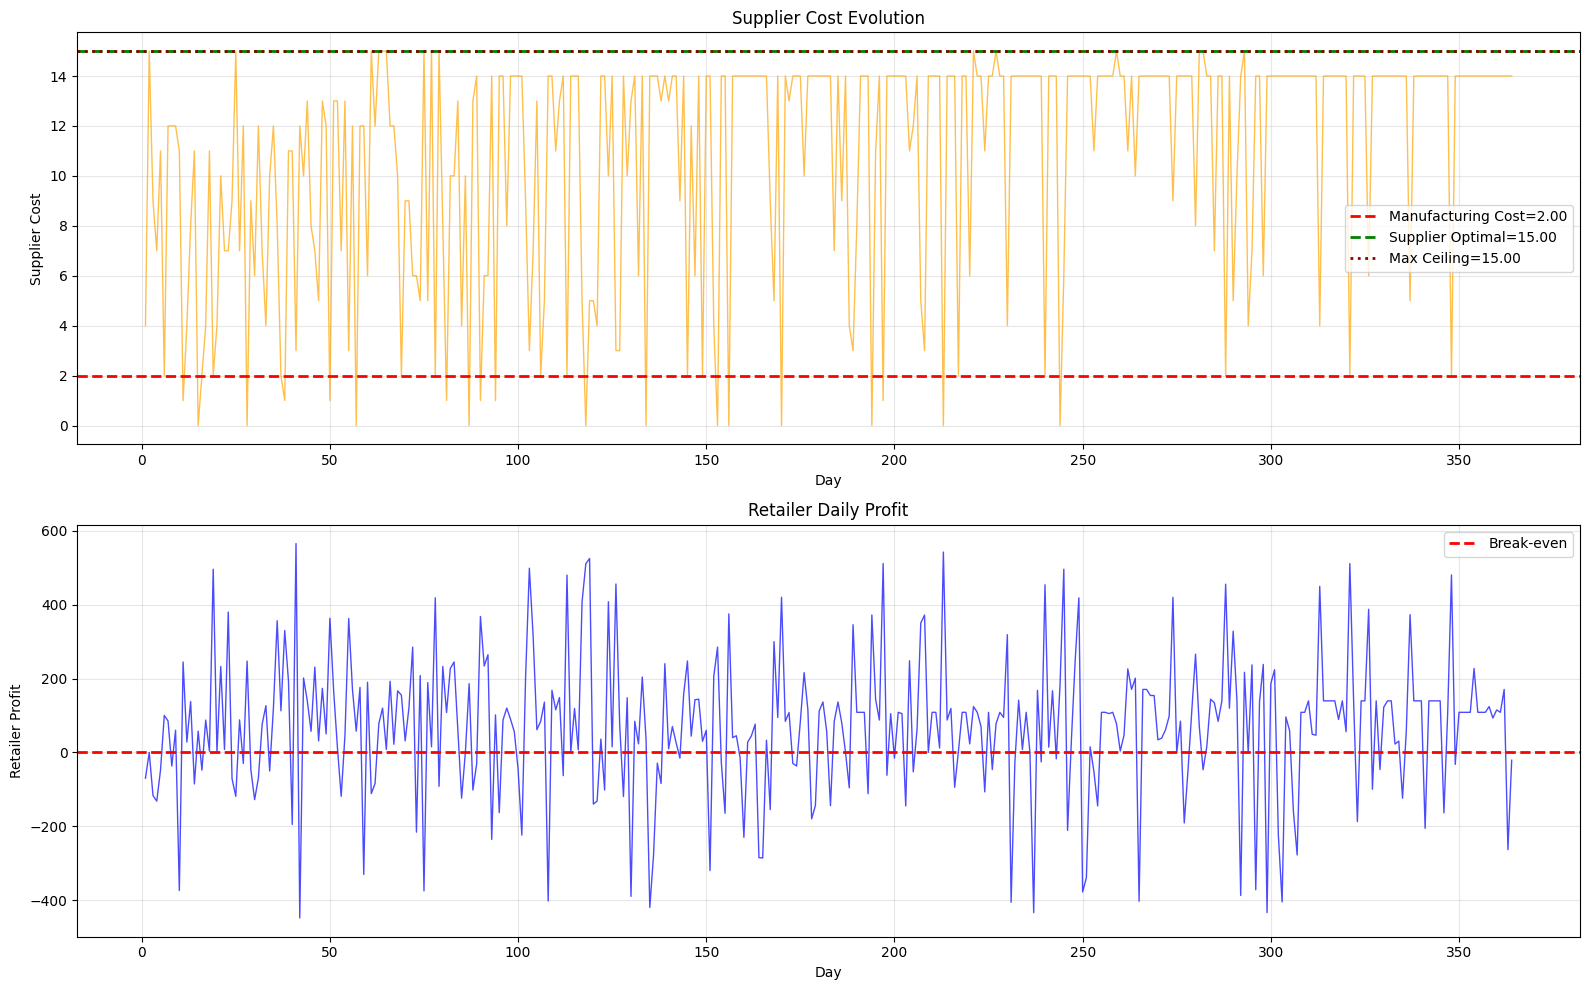


7. PROBLEM DIAGNOSIS:
   ✅ Average retailer profit is POSITIVE
      - Supplier cost ceiling is working effectively
   ⚠️ Only 71.4% of days have positive retailer profit
      - Supplier is still exploring high costs during learning



In [6]:
# ============================================================================
# DIAGNOSTIC: Analyze Supplier Behavior
# ============================================================================

print("=" * 80)
print("🔍 DIAGNOSTIC: SUPPLIER COST ANALYSIS")
print("=" * 80)

if len(competitive_results) > 0:
    # Pick first competitive result to analyze
    sample_result = competitive_results[0]
    df = sample_result['Combined_DF']
    
    print(f"\nAnalyzing: {sample_result['Config']}")
    print(f"\n1. SUPPLIER COST STATISTICS:")
    print(f"   Mean Cost: {df['Cost'].mean():.2f}")
    print(f"   Median Cost: {df['Cost'].median():.2f}")
    print(f"   Min Cost: {df['Cost'].min():.2f}")
    print(f"   Max Cost: {df['Cost'].max():.2f}")
    print(f"   Std Dev: {df['Cost'].std():.2f}")
    print(f"   Max Ceiling: {params.SUPPLIER_MAX_COST:.2f}")
    
    print(f"\n2. RETAILER PROFIT STATISTICS:")
    print(f"   Mean Profit: {df['Retailer_Profit'].mean():.2f}")
    print(f"   Median Profit: {df['Retailer_Profit'].median():.2f}")
    print(f"   Min Profit: {df['Retailer_Profit'].min():.2f}")
    print(f"   Max Profit: {df['Retailer_Profit'].max():.2f}")
    print(f"   Days with positive profit: {(df['Retailer_Profit'] > 0).sum()} / {len(df)} ({(df['Retailer_Profit'] > 0).sum()/len(df)*100:.1f}%)")
    print(f"   Days with negative profit: {(df['Retailer_Profit'] < 0).sum()} / {len(df)} ({(df['Retailer_Profit'] < 0).sum()/len(df)*100:.1f}%)")
    
    print(f"\n3. SUPPLIER PROFIT STATISTICS:")
    print(f"   Mean Profit: {df['Supplier_Profit'].mean():.2f}")
    print(f"   Median Profit: {df['Supplier_Profit'].median():.2f}")
    print(f"   Min Profit: {df['Supplier_Profit'].min():.2f}")
    print(f"   Max Profit: {df['Supplier_Profit'].max():.2f}")
    
    print(f"\n4. BENCHMARKS:")
    print(f"   SUPPLIER_OPTIMAL_COST: {params.SUPPLIER_OPTIMAL_COST:.2f}")
    print(f"   MANUFACTURING_COST: {params.MANUFACTURING_COST:.2f}")
    print(f"   SUPPLIER_MAX_COST (Ceiling): {params.SUPPLIER_MAX_COST:.2f}")
    
    print(f"\n5. EARLY ROUNDS (First 50 days):")
    early = df.head(50)
    print(f"   Avg Supplier Cost: {early['Cost'].mean():.2f}")
    print(f"   Avg Retailer Profit: {early['Retailer_Profit'].mean():.2f}")
    print(f"   Avg Supplier Profit: {early['Supplier_Profit'].mean():.2f}")
    
    print(f"\n6. LATE ROUNDS (Last 50 days):")
    late = df.tail(50)
    print(f"   Avg Supplier Cost: {late['Cost'].mean():.2f}")
    print(f"   Avg Retailer Profit: {late['Retailer_Profit'].mean():.2f}")
    print(f"   Avg Supplier Profit: {late['Supplier_Profit'].mean():.2f}")
    
    # Plot supplier cost and retailer profit evolution
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Supplier Cost over time
    axes[0].plot(df['Step'], df['Cost'], alpha=0.7, linewidth=1, color='orange')
    axes[0].axhline(params.MANUFACTURING_COST, color='red', linestyle='--', linewidth=2, label=f'Manufacturing Cost={params.MANUFACTURING_COST:.2f}')
    axes[0].axhline(params.SUPPLIER_OPTIMAL_COST, color='green', linestyle='--', linewidth=2, label=f'Supplier Optimal={params.SUPPLIER_OPTIMAL_COST:.2f}')
    axes[0].axhline(params.SUPPLIER_MAX_COST, color='darkred', linestyle=':', linewidth=2, label=f'Max Ceiling={params.SUPPLIER_MAX_COST:.2f}')
    axes[0].set_xlabel('Day')
    axes[0].set_ylabel('Supplier Cost')
    axes[0].set_title('Supplier Cost Evolution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Retailer Profit over time
    axes[1].plot(df['Step'], df['Retailer_Profit'], alpha=0.7, linewidth=1, color='blue')
    axes[1].axhline(0, color='red', linestyle='--', linewidth=2, label='Break-even')
    axes[1].set_xlabel('Day')
    axes[1].set_ylabel('Retailer Profit')
    axes[1].set_title('Retailer Daily Profit')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Check if supplier is charging too much
    print(f"\n7. PROBLEM DIAGNOSIS:")
    if df['Retailer_Profit'].mean() < 0:
        print("   ⚠️ WARNING: Average retailer profit is NEGATIVE")
        print(f"      - Supplier avg cost ({df['Cost'].mean():.2f}) may be too high")
        print(f"      - Consider lowering SUPPLIER_MAX_COST further")
    else:
        print("   ✅ Average retailer profit is POSITIVE")
        print(f"      - Supplier cost ceiling is working effectively")
    
    positive_pct = (df['Retailer_Profit'] > 0).sum() / len(df) * 100
    if positive_pct < 80:
        print(f"   ⚠️ Only {positive_pct:.1f}% of days have positive retailer profit")
        print(f"      - Supplier is still exploring high costs during learning")
    else:
        print(f"   ✅ {positive_pct:.1f}% of days have positive retailer profit")

print("\n" + "=" * 80)